In [1]:
"""
jupyter-nbconvert report_regime_distribs.ipynb --to python; python -u report_regime_distribs.py

"""

'\njupyter-nbconvert report_regime_distribs.ipynb --to python; python -u report_regime_distribs.py\n\n'

In [2]:
from __future__ import division
import os
import glob
import pickle
from natsort import natsorted
import argparse
import os
import sys
import numpy as np
import tqdm
import pandas as pd

import scipy as sp
import numpy as np
from pprint import pprint
import glob
import sys
sys.path.append('../')
from plume_env import PlumeEnvironment, PlumeFrameStackEnvironment
import config
import agents
import agent_analysis
import os
import sklearn
import sklearn.decomposition as skld

import importlib
import log_analysis
importlib.reload(log_analysis)

<module 'log_analysis' from '../log_analysis.py'>

In [3]:
import sys
batchmode = False
if 'ipykernel_launcher' in sys.argv[0]:
    print("Interactive mode")
else:
    batchmode = True
    print("Batch/CLI mode")
    import argparse

Interactive mode


In [4]:
# Common
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(style="white")
# print(plt.style.available)

mpl.rcParams['figure.dpi'] = 100
dpi_save = 300
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

# Interactive vs. CLI
if not batchmode:
    %matplotlib inline
    # %config InlineBackend.figure_format = 'svg'
    %config InlineBackend.figure_format = 'retina'
if batchmode:
    matplotlib.use("Agg")
    
pca3d_figsize=(10,5)

In [5]:
# # Do this at the end to get things to work
# import matplotlib
# import matplotlib.pyplot as plt
# import matplotlib as mpl


# import seaborn as sns
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# from IPython.display import clear_output
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D


# %matplotlib inline
# # %config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'retina'


# import seaborn as sns
# sns.set(style="white")
# print(plt.style.available)
# # plt.style.use('seaborn-ticks')

# # sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":9})   


# mpl.rcParams['figure.dpi'] = 100
# font = {'family' : 'serif',
#         'weight' : 'normal',
#         'size'   : 18}
# matplotlib.rc('font', **font)
# # plt.rcParams["font.family"] = "Times New Roman"

In [6]:
# Common
# outcome_colormap = {'HOME': 'green', 
#                     'OOB':'red', 
#                     'OOT':'blue'
#                    }

outcome_colormap = {'HOME': 'skyblue', 
                    'OOB':'orange', 
                    'OOT':'blue'
                   }

regime_colormap = {'SEARCH': 'red', 
                   'TRACK':'green', 
                   'RECOVER':'blue', 
                   'WARMUP':'cyan'
                  }

# https://seaborn.pydata.org/generated/seaborn.set_color_codes.html#seaborn.set_color_codes
sns.color_palette()
sns.set_color_codes(palette='deep')

In [7]:
if batchmode:
    parser = argparse.ArgumentParser(description='')
    parser.add_argument('--model_fname', default=None)
    parser.add_argument('--datasets', type=str, nargs='+',
            default=['constantx5b5', 'switch45x5b5', 'noisy3x5b5'])
    parser.add_argument('--dataset', type=str, default='constantx5b5')
    args = parser.parse_args()
    print(args)

    model_fname = args.model_fname

In [8]:
if not batchmode: # Interactive
    model_fname = natsorted(glob.glob(f'/home/satsingh/plume/plumezoo/latest/fly/memory/*VRNN*.pt'))[0]
#     model_fname = natsorted(glob.glob(f'/home/satsingh/plume/plumezoo/dynamic/fly/memory/*VRNN*.pt'))[0]



In [9]:
model_dir = model_fname.replace('.pt', '/')
print("model_dir", model_dir)

model_seed = model_dir.split('seed')[-1].split('/')[0]

outdir = f"{model_dir}/report_regime_dists/"
os.makedirs(outdir, exist_ok=True)
print(outdir)

is_recurrent = True if ('GRU' in model_dir) or ('VRNN' in model_dir) else False

logfiles = natsorted(glob.glob(model_dir + '*.pkl'))
[ x.split('/')[-1] for x in logfiles ]

model_dir /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed3307e9/
/home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed3307e9//report_regime_dists/


['constantx5b5.pkl',
 'constantx5b5_0.2.pkl',
 'constantx5b5_0.4.pkl',
 'constantx5b5_0.6.pkl',
 'constantx5b5_0.8.pkl',
 'noisy3x5b5.pkl',
 'noisy6x5b5.pkl',
 'switch15x5b5.pkl',
 'switch30x5b5.pkl',
 'switch45x5b5.pkl']

In [10]:
# use_datasets = ['constantx5b5', 'switch45x5b5', 'noisy6x5b5']
use_datasets = ['constantx5b5', 'switch45x5b5', 'noisy3x5b5']

# use_datasets = ['constantx5b5']
selected_df = log_analysis.get_selected_df(model_dir, 
                              use_datasets, 
                              n_episodes_home=60, 
                              n_episodes_other=60,
                              balanced=True,
                              min_ep_steps=0)
print(selected_df.shape)
selected_df

(298, 5)


,dataset,idx,ep_length,log,outcome
3,constantx5b5,82,285,"{'trajectory': [[6.089736038791369, 0.00960661...",HOME
7,constantx5b5,97,276,"{'trajectory': [[5.948685860931586, 0.05904046...",HOME
8,constantx5b5,102,275,"{'trajectory': [[5.942676230501777, 0.03266931...",HOME
9,constantx5b5,236,275,"{'trajectory': [[8.044839745325845, -0.4675270...",HOME
10,constantx5b5,92,275,"{'trajectory': [[5.991609051625939, 0.09911625...",HOME
...,...,...,...,...,...
319,noisy3x5b5,27,52,"{'trajectory': [[3.984323325354093, 0.58274205...",OOB
320,noisy3x5b5,33,52,"{'trajectory': [[4.034063828657129, 0.68613060...",OOB
321,noisy3x5b5,23,51,"{'trajectory': [[3.941389059537711, 0.73158124...",OOB
322,noisy3x5b5,100,50,"{'trajectory': [[5.941629538577946, 0.93596513...",OOB


In [11]:
selected_df.groupby(['dataset', 'outcome']).count()

idx  ep_length  log
dataset      outcome                     
constantx5b5 HOME      33         33   33
             OOB       33         33   33
noisy3x5b5   HOME      56         56   56
             OOB       56         56   56
switch45x5b5 HOME      60         60   60
             OOB       60         60   60

In [12]:
traj_dfs = []
squash_action = True
# for episode_log in tqdm.tqdm(selected_df['log']):
for idx,row in tqdm.tqdm(selected_df.iterrows()):
    dataset = row['dataset']
    episode_log = row['log']

    traj_df = log_analysis.get_traj_df(episode_log, 
                                       extended_metadata=True, 
                                       squash_action=squash_action)
    traj_df['idx'] = np.arange(traj_df.shape[0], dtype=int)
    traj_df['ep_idx'] = row['idx']
    traj_df['dataset'] = dataset
    traj_df['outcome'] = row['outcome']
    traj_df['loc_x_dt'] = traj_df['loc_x'].diff() 
    traj_df['loc_y_dt'] = traj_df['loc_y'].diff() 
    
    traj_dfs.append(traj_df)
    
traj_df_stacked = pd.concat(traj_dfs)

print(traj_df_stacked.shape)
traj_df_stacked.columns

298it [00:12, 24.32it/s]


(56890, 69)


Index(['loc_x', 'loc_y', 't_val', 'wind_theta_obs', 'wind_x_obs', 'wind_y_obs',
       'step', 'turn', 'odor_obs', 'stray_distance', 'odor_01', 'odor_clip',
       'odor_lastenc', 'regime', 'agent_angle_ground', 'wind_angle_ground',
       'wind_speed_ground', 't_val_norm', 'odor_enc_2', 'odor_enc_4',
       'odor_enc_6', 'odor_enc_8', 'odor_enc_10', 'odor_enc_12', 'odor_enc_14',
       'odor_enc_16', 'odor_enc_18', 'odor_ewm', 'odor_ewm_2', 'odor_ewm_4',
       'odor_ewm_6', 'odor_ewm_8', 'odor_ewm_10', 'odor_ewm_12', 'odor_ewm_14',
       'odor_ewm_16', 'odor_ewm_18', 'odor_ma', 'odor_ma_2', 'odor_ma_4',
       'odor_ma_6', 'odor_ma_8', 'odor_ma_10', 'odor_ma_12', 'odor_ma_14',
       'odor_ma_16', 'odor_ma_18', 'odor_lastenc_norm', 'radius', 'r_step',
       'loc_x_dt1', 'loc_y_dt1', 'wind_theta_obs_dt1', 'odor_obs_dt1',
       'odor_01_dt1', 'odor_clip_dt1', 'odor_lastenc_dt1', 'radius_dt1',
       'stray_distance_dt1', 'r_step_dt1', 'agent_angle_ground_dt1',
       'wind_angle_gro

In [13]:
traj_df_stacked['tidx'] = (traj_df_stacked['t_val']*100).astype(int)
traj_df_stacked['agent_angle_ground_unshifted'] = traj_df_stacked['agent_angle_ground']
traj_df_stacked['agent_angle_ground'] = (traj_df_stacked['agent_angle_ground']+0.5).apply(lambda x: x-1. if x>1 else x)

# Course angle
traj_df_stacked['course_angle_ground'] = log_analysis.shift_scale_theta(log_analysis.wind_xy_to_theta(traj_df_stacked['loc_x_dt'], traj_df_stacked['loc_y_dt'])) 
# traj_df_stacked['course_angle_ground'] = np.arctan2(traj_df_stacked['loc_x_dt'], traj_df_stacked['loc_y_dt'])/np.pi
# traj_df_stacked['course_angle_ground'] = (traj_df_stacked['course_angle_ground'] + 1)/2 # to 0--1
traj_df_stacked['course_angle_ground_unshifted'] = traj_df_stacked['course_angle_ground'].copy()
traj_df_stacked['course_angle_ground'] = (traj_df_stacked['course_angle_ground']+0.5).apply(lambda x: x-1. if x>1 else x)

# plt.scatter(traj_df_stacked['loc_x_dt'], traj_df_stacked['loc_y_dt'], s=5)
# plt.plot(np.arctan(traj_df_stacked['loc_y_dt']/traj_df_stacked['loc_x_dt'])/np.pi )

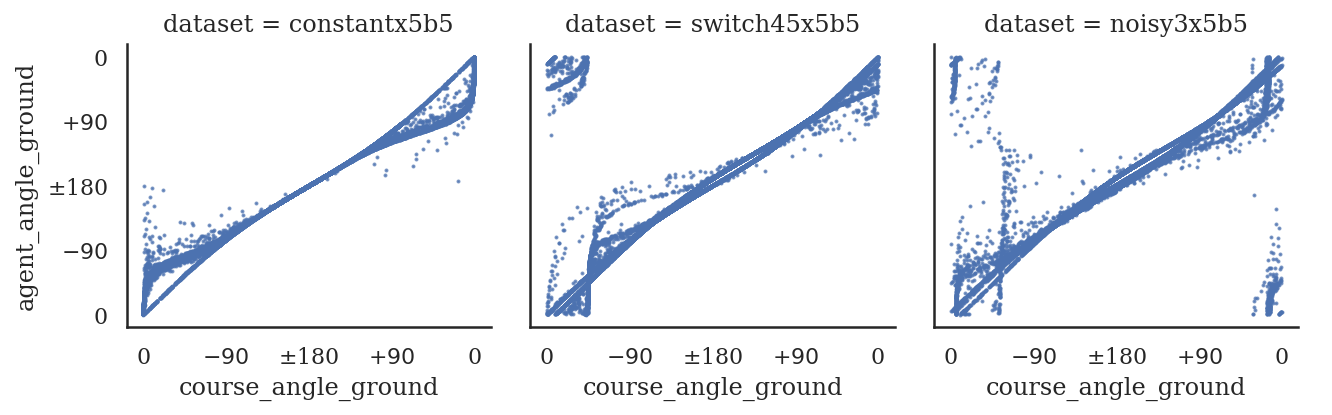

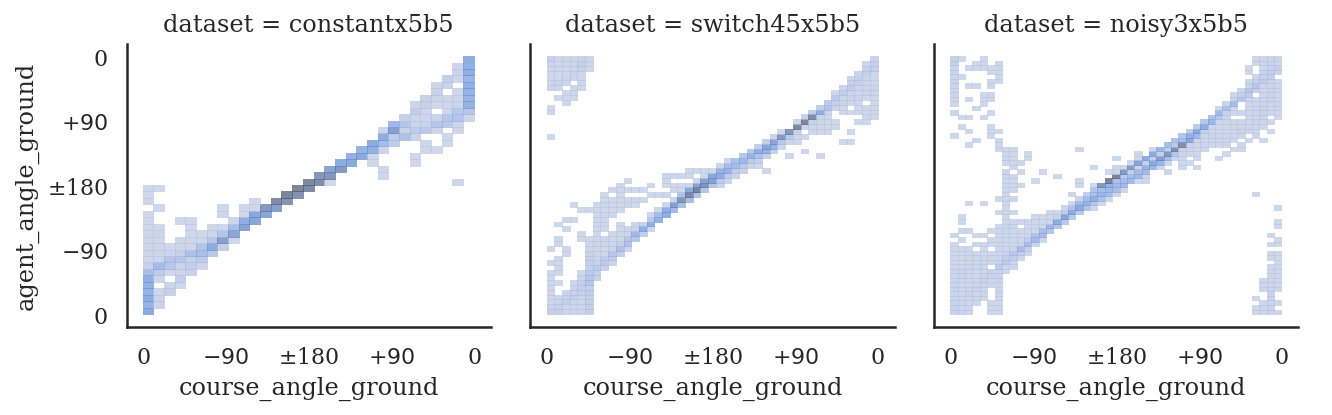

In [14]:
def label_axes(ax, x, y):
    ticks = [0, 0.25, 0.5, 0.75, 1.0]
    ticklabels = [0, r'$-90$', r'$\pm$180', r'$+90$', 0]
    ticklabels_u = [r'-180', r'$-90$', r'$0$', r'$+90$', r'$+180$']
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ticklabels_u if 'unshifted' in x else ticklabels)
    ax.set_yticklabels(ticklabels_u if 'unshifted' in y else ticklabels)


g = sns.FacetGrid(traj_df_stacked, col ="dataset")
x = "course_angle_ground"
y = "agent_angle_ground"
# x = "course_angle_ground_unshifted"
# y = "agent_angle_ground_unshifted"

g.map(plt.scatter, 
      x, y, 
      edgecolor=None, 
      s=1,
      alpha=0.7,
     ).add_legend()

ax = plt.gca()
label_axes(ax, x, y)
plt.show()


g = sns.FacetGrid(traj_df_stacked, col ="dataset")
g.map(sns.histplot, 
      x, y, 
      alpha=0.7,
     ).add_legend()
ax = plt.gca()
label_axes(ax, x, y)
plt.show()

# plt.ylim(0,1)



## Extract/Stack trajectory data

In [15]:
# traj_df_stacked.groupby(by='regime').hist()
analysis_columns = [
    'agent_angle_ground',
#     'odor_lastenc', # redundant, defined using this
    'loc_x_dt',
    'loc_y_dt',
#     'r_step',
    'turn',
    'step',
    'stray_distance',
]

# for col in analysis_columns:
#     print(col)
# #     sharex = False if col in ['odor_lastenc'] else True
#     sharex = True
#     traj_df_stacked[col].hist(by=traj_df_stacked['regime'], 
#                                                layout=(3,1), 
#                                                figsize=(2, 4),
#                                                sharex=sharex, 
# #                                                sharey=True,
#                                               )
#     plt.tight_layout()
#     plt.show()



In [16]:
titles_dict = {'agent_angle_ground':'Head\n' + r'direction [$^{\circ}$]',
               'loc_x_dt':r'$\Delta$x [m]',
               'loc_y_dt':r'$\Delta$y [m]',
               'turn':'Turn\nAction [R-L] ',
               'step':'Move\nAction [0-1]',
               'stray_distance':'Stray\nDistance [m]'
              }
ticks_dict = {'agent_angle_ground':[0, 0.25, 0.5, 0.75, 1.0],
               'loc_x_dt':[-0.1, 0, 0.1],
               'loc_y_dt':[-0.1, 0, 0.1],
               'stray_distance':[0, 1, 2],
               'turn':[0,1],
               'step':[0,1],
              }
ticklabels_dict = {
#     'agent_angle_ground':[0, r'$\frac{-\pi}{2}$', r'$\pm\pi$', r'$\frac{+\pi}{2}$', 0],
    'agent_angle_ground':[0, r'$-90$', r'$\pm$180', r'$+90$', 0],
    'turn':['R','L'],
              }
xlims_dict = {
    'agent_angle_ground':(0.,1.),
#     'stray_distance':(0.,2.),
}

['TRACK', 'RECOVER', 'SEARCH']
$\mathbf{Track}$
$\mathbf{Recover}$
$\mathbf{Search}$
Saving: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed3307e9//report_regime_dists//regime_histos_3307e9.png


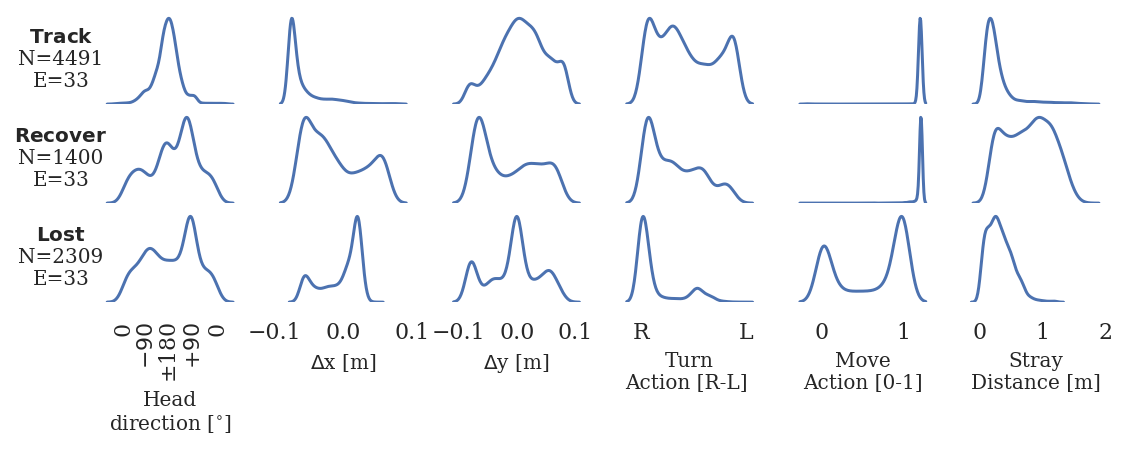

In [59]:
datasets = ['constantx5b5']
# datasets = ['switch45x5b5']
# datasets = ['noisy3x5b5']

# Manuscript ready
n_cols = len(analysis_columns)
# regimes = traj_df_stacked['regime'].unique()
regimes = ['TRACK', 'RECOVER', 'SEARCH']
print(regimes)
n_regimes = len(regimes)
# fig = plt.figure(figsize=(7,2)) 
fig, axes = plt.subplots(n_regimes, n_cols, sharex=False, sharey=False, figsize=(9,2.65))
gs = matplotlib.gridspec.GridSpec(nrows=n_regimes, 
                       ncols=n_cols, 
                       figure=fig, 
                       width_ratios=[1]*n_cols,
                       height_ratios=[1]*n_regimes,
#                        wspace=-0.2, 
#                       hspace=0.1
                      )

traj_df_stacked_subset = traj_df_stacked.query("dataset in @datasets")
E=len(traj_df_stacked_subset['ep_idx'].unique())

for i, col in enumerate(analysis_columns):
    for j, regime in enumerate(regimes): 
        ax=axes[j, i]
        traj_df_stacked_subset = traj_df_stacked.query("regime == @regime and dataset in @datasets")
        sns.distplot(traj_df_stacked_subset[col],
#                      bins=np.asarray(bins_use), 
#                      kde=True,
#                      color=img_colors[i],
#                      color='blue',
                     hist=False,
                     rug=False,
                     ax=ax,
#                      norm_hist=normalize_dists,
                     hist_kws=dict(alpha=1))
        ax.set_yticks([])
        [ax.spines[s].set_visible(False) for s in ax.spines]
        ax.set_ylabel('')

        
        N=len(traj_df_stacked_subset)
#         suffix = f"\nN={N}"
#         suffix = f"\n(E={E})"
        suffix = f"\nN={N}\nE={E}"



        if i == 0:
#             ax.set_ylabel(regimes[j].lower().capitalize() + suffix, fontsize=10, )
            prefix = "$\mathbf{{{}}}$".format(regimes[j].lower().capitalize())
            print(prefix)
            ax.set_ylabel(r"{}".format(prefix) + suffix, fontsize=10, 
                              rotation=0, ha='center', labelpad=20, va='center')
            if regimes[j] == 'SEARCH':
#                 ax.set_ylabel(r"$\mathbf{Lost}$" + suffix, fontsize=10)
                ax.set_ylabel(r"$\mathbf{Lost}$" + suffix, fontsize=10, 
                              rotation=0, ha='center', labelpad=20, va='center') #  

        if j < 2:
            ax.set_xticks([])
            ax.set_xlabel('')
        if j == 2:
            ax.set_xticks(ticks_dict[col])
            ax.set_xlabel(titles_dict[col], fontsize=10,)
            if col in ticklabels_dict.keys():
                ax.set_xticklabels(ticklabels_dict[col])
                if col == 'agent_angle_ground':
                    ax.set_xticklabels(ticklabels_dict[col], rotation=90)

            
fig.subplots_adjust(hspace=.1, wspace=0.25)
# plt.tight_layout()

fname = f"{outdir}/regime_histos_{model_seed}.png"
print("Saving:", fname)
plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')

In [18]:
# r_counts = traj_df['regime'].value_counts()
# for key in ['TRACK', 'RECOVER', 'SEARCH']:
#     if key not in r_counts.keys():
#         r_counts[key] = 0
# r_counts['TRACK'], r_counts['RECOVER'], r_counts['SEARCH']

## Head direction in different reference frames
* Referenced to -- ground x-axis
* Referenced to -- wind-angle
* Referenced to -- centerline angle

In [19]:
print(traj_df_stacked.shape)
traj_df_stacked.query("outcome == 'HOME'", inplace=True)
print(traj_df_stacked.shape)

(56890, 73)
(29069, 73)


In [20]:
dataset = 'noisy3x5b5'
# dataset = 'switch45x5b5'
# regime = 'SEARCH'
# regime = 'RECOVER'
regime = 'TRACK'
# datasets = ['noisy3x5b5']



def load_centerline_df(dataset, traj_df_stacked):
    print(dataset)
    centerline_filename = f'{config.datadir}/centerline_data_{dataset}.pickle' 
    centerline_df = pd.read_pickle(centerline_filename)
    env_dt_int = 4
    centerline_df.query("tidx % @env_dt_int == 0", inplace=True)

    tidx_min = traj_df_stacked['tidx'].min()
    tidx_max = traj_df_stacked['tidx'].max()
    print(centerline_df.shape)
    centerline_df.query(" @tidx_min <= tidx <= @tidx_max ", inplace=True)
    print(centerline_df.shape)

    return centerline_df

centerline_df = load_centerline_df(dataset, traj_df_stacked)

noisy3x5b5
(6167393, 7)
(857273, 7)


0.546387    75704
0.511914    63558
0.614405    44573
0.649924    40959
0.630486    34259
            ...  
0.548535        1
0.544408        1
0.555513        1
0.561204        1
0.554294        1
Name: angle, Length: 4893, dtype: int64

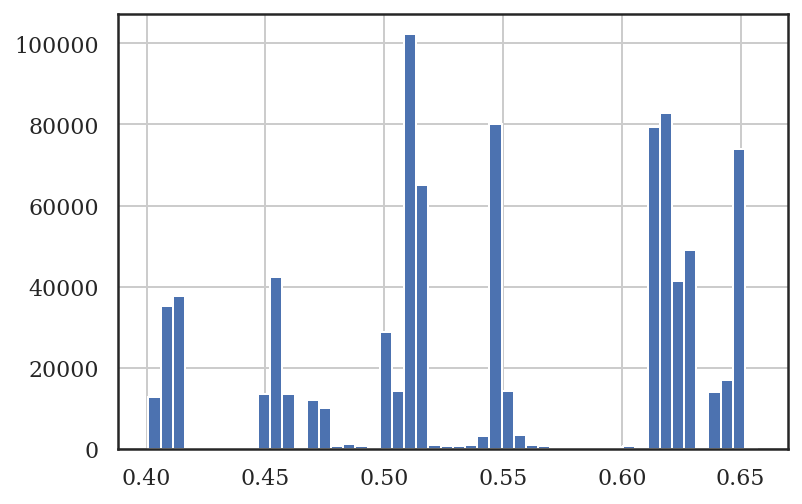

In [21]:
# centerline_df['angle'].hist(bins=50)
centerline_df['angle'].hist(bins=50)
# np.histogram(centerline_df['angle'])
centerline_df['angle'].value_counts()

In [22]:

traj_df_stacked.columns
# traj_df_stacked.head()

Index(['loc_x', 'loc_y', 't_val', 'wind_theta_obs', 'wind_x_obs', 'wind_y_obs',
       'step', 'turn', 'odor_obs', 'stray_distance', 'odor_01', 'odor_clip',
       'odor_lastenc', 'regime', 'agent_angle_ground', 'wind_angle_ground',
       'wind_speed_ground', 't_val_norm', 'odor_enc_2', 'odor_enc_4',
       'odor_enc_6', 'odor_enc_8', 'odor_enc_10', 'odor_enc_12', 'odor_enc_14',
       'odor_enc_16', 'odor_enc_18', 'odor_ewm', 'odor_ewm_2', 'odor_ewm_4',
       'odor_ewm_6', 'odor_ewm_8', 'odor_ewm_10', 'odor_ewm_12', 'odor_ewm_14',
       'odor_ewm_16', 'odor_ewm_18', 'odor_ma', 'odor_ma_2', 'odor_ma_4',
       'odor_ma_6', 'odor_ma_8', 'odor_ma_10', 'odor_ma_12', 'odor_ma_14',
       'odor_ma_16', 'odor_ma_18', 'odor_lastenc_norm', 'radius', 'r_step',
       'loc_x_dt1', 'loc_y_dt1', 'wind_theta_obs_dt1', 'odor_obs_dt1',
       'odor_01_dt1', 'odor_clip_dt1', 'odor_lastenc_dt1', 'radius_dt1',
       'stray_distance_dt1', 'r_step_dt1', 'agent_angle_ground_dt1',
       'wind_angle_gro

count    29069.000000
mean         0.547315
std          0.071590
min          0.409498
25%          0.500000
50%          0.500000
75%          0.625000
max          0.648936
Name: wind_angle_ground, dtype: float64

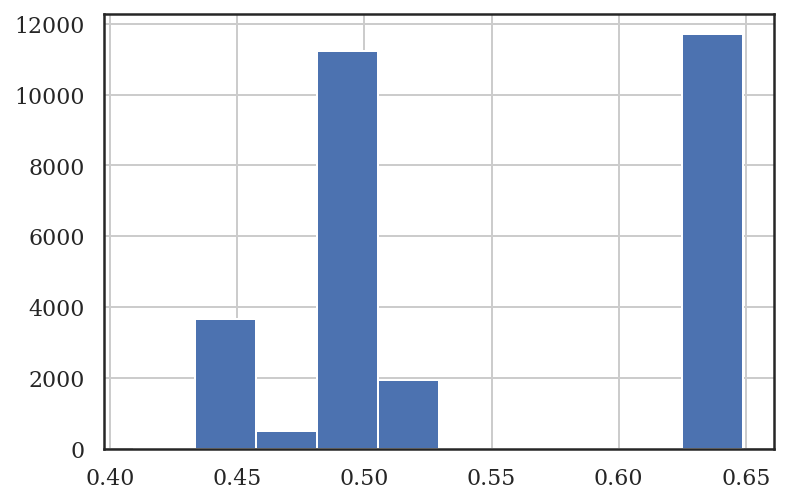

In [23]:
# Improvement -- Exclude timesteps when wind is blowing close to 0-degrees
def trim_small_wind_angles(df, degrees_omit=15):
    def deg_to_01(deg):
        assert deg >= -180 and deg <= 180
        return 0.5 + deg/360
#     degrees_omit = 15 # range of degrees +/- to exclude

    wag_exclude_min = deg_to_01(-degrees_omit)
    wag_exclude_max = deg_to_01(+degrees_omit)
    print(f"Trimming out {wag_exclude_min} to {wag_exclude_max}")
    df_return = df.query("(wind_angle_ground <= @wag_exclude_min) or (wind_angle_ground >= @wag_exclude_max)")
    return df_return

# traj_df_stacked = trim_small_wind_angles(traj_df_stacked, degrees_omit=15)

traj_df_stacked['wind_angle_ground'].hist()
traj_df_stacked['wind_angle_ground'].describe()

In [24]:
def subset_centerline_angle(traj_df_stacked, regime, dataset):
    traj_df_stacked['centerline_angle'] = 0
    traj_df_stacked_subset = traj_df_stacked.query("regime == @regime and dataset in @dataset")[:]
    if dataset in ['switch45x5b5']:
        traj_df_stacked_subset = trim_small_wind_angles(traj_df_stacked_subset, degrees_omit=15)
    print(traj_df_stacked_subset.shape)
    for idx, row in tqdm.tqdm(traj_df_stacked_subset.iterrows()):
        loc_x = row['loc_x']
        tidx = row['tidx']

        s = centerline_df.query('tidx == @tidx and @loc_x-0.02 <= x <= @loc_x+0.02')['angle'].median()
        traj_df_stacked_subset.loc[idx, 'centerline_angle'] = s
    #     print(idx, s)
    return traj_df_stacked_subset


# TODO -- use a distance based rule
# def subset_centerline_angle(traj_df_stacked, regime, dataset):
#     traj_df_stacked['centerline_angle'] = 0
#     traj_df_stacked_subset = traj_df_stacked.query("regime == @regime and dataset in @dataset")[:]
#     if dataset in ['switch45x5b5']:
#         traj_df_stacked_subset = trim_small_wind_angles(traj_df_stacked_subset, degrees_omit=15)
#     print(traj_df_stacked_subset.shape)
#     for idx, row in tqdm.tqdm(traj_df_stacked_subset.iterrows()):
#         loc_x = row['loc_x']
#         tidx = row['tidx']

#         Z = centerline_df.query('tidx == @tidx').loc[:,['x','y']]
#         Z = Z.sample(n=max_samples, replace=False) if Z.shape[0] > max_samples else Z

#         s = centerline_df.query('tidx == @tidx and @loc_x-0.02 <= x <= @loc_x+0.02')['angle'].median()
#         traj_df_stacked_subset.loc[idx, 'centerline_angle'] = s
#     #     print(idx, s)
#     return traj_df_stacked_subset
    
traj_df_stacked_subset = subset_centerline_angle(traj_df_stacked, regime, dataset)

14it [00:00, 136.33it/s]

(6169, 74)


6169it [00:44, 138.38it/s]


In [25]:
# traj_df_stacked_subset['centerline_angle'] = log_analysis.shift_scale_theta( traj_df_stacked_subset['centerline_angle'] )
# traj_df_stacked_subset['centerline_angle'].hist()

<AxesSubplot:>

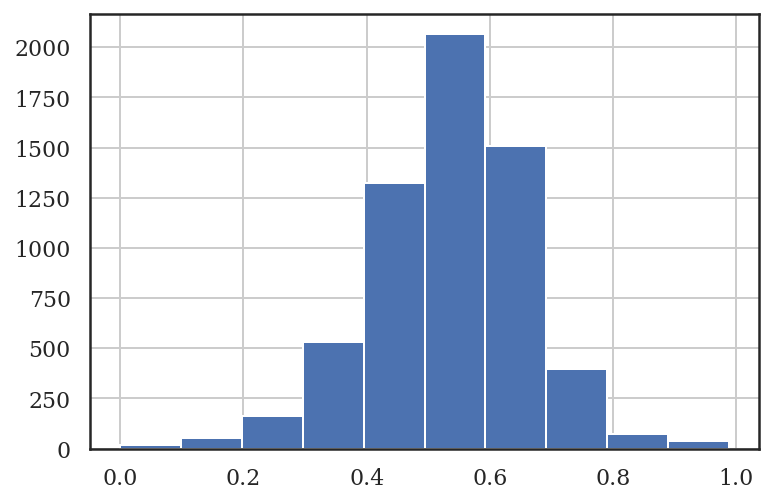

In [26]:
traj_df_stacked_subset['agent_angle_ground'].hist()

count    6169.000000
mean        0.517236
std         0.082534
min         0.409498
25%         0.452564
50%         0.461444
75%         0.648936
max         0.648936
Name: wind_angle_ground, dtype: float64

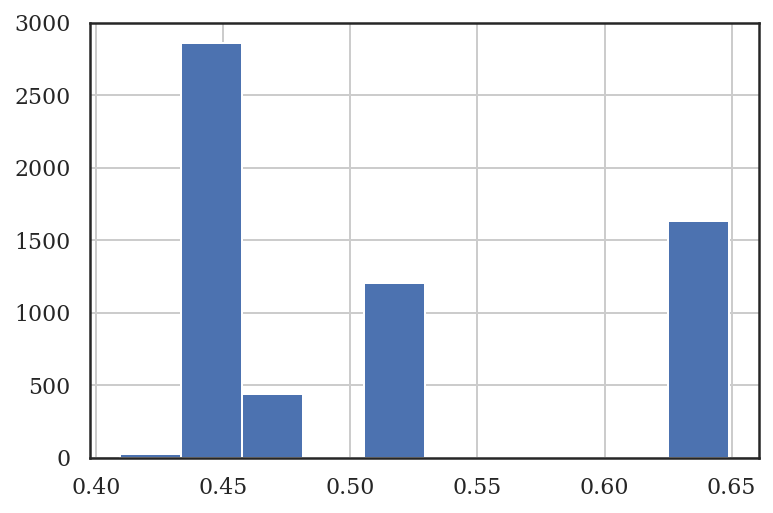

In [27]:
traj_df_stacked_subset['wind_angle_ground'].hist()
traj_df_stacked_subset['wind_angle_ground'].describe()

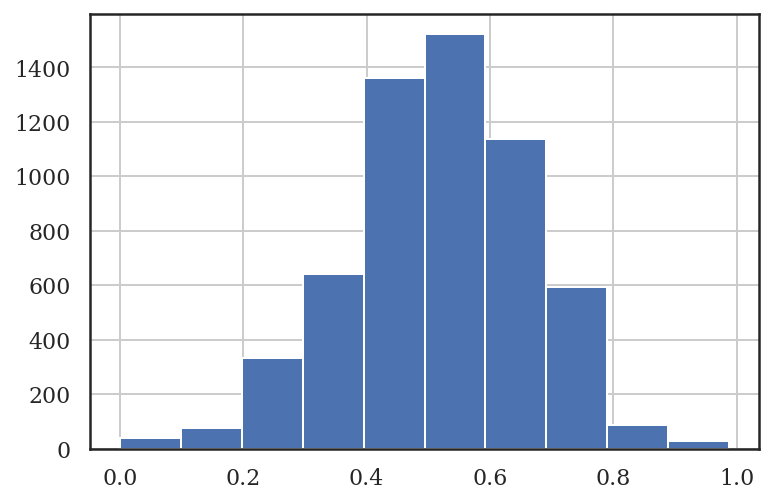

In [28]:
def roll_around_angle(a):
    if a <= 1.0 and a >= 0.0:
        return a
    elif a > 1.0:
        return a - 1.0
    else:
        return 1.0 + a


def augment_agent_angle_centerline(traj_df_stacked_subset):
    traj_df_stacked_subset['agent_angle_centerline'] = traj_df_stacked_subset['agent_angle_ground'] - (traj_df_stacked_subset['centerline_angle'] - 0.5)    
    traj_df_stacked_subset['agent_angle_centerline'] = traj_df_stacked_subset['agent_angle_centerline'].apply(roll_around_angle)
    traj_df_stacked_subset['agent_angle_centerline'].hist()
    traj_df_stacked_subset['agent_angle_centerline'].describe()
    
augment_agent_angle_centerline(traj_df_stacked_subset)

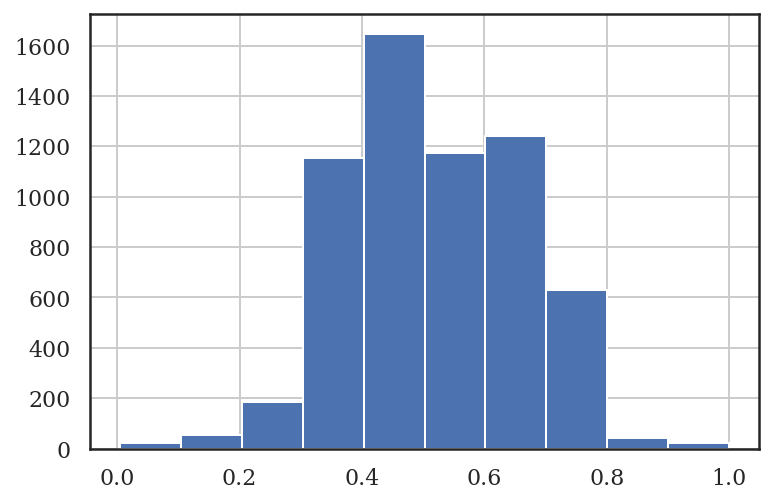

In [29]:
def augment_agent_angle_wind(traj_df_stacked_subset):
    traj_df_stacked_subset['agent_angle_wind'] = traj_df_stacked_subset['agent_angle_ground'] - (traj_df_stacked_subset['wind_angle_ground'] - 0.5)    
    traj_df_stacked_subset['agent_angle_wind'] = traj_df_stacked_subset['agent_angle_wind'].apply(roll_around_angle)
    traj_df_stacked_subset['agent_angle_wind'].hist()
    traj_df_stacked_subset['agent_angle_wind'].describe()
    
augment_agent_angle_wind(traj_df_stacked_subset)    

Saving: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed3307e9//report_regime_dists//regime_dists_3307e9_noisy3x5b5_TRACK_HD.png


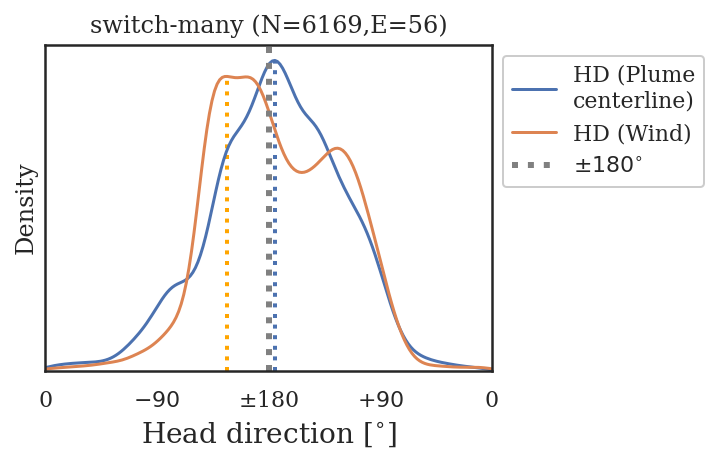

In [30]:
def plot_agent_angle_dists(traj_df_stacked_subset, regime, dataset):
    
    label_dict = {
        'agent_angle_ground': 'HD (Ground)',
        'agent_angle_centerline': f'HD (Plume\ncenterline)',
        'agent_angle_wind': 'HD (Wind)',        
    }
    title_dataset_dict = {
        'constantx5b5': 'constant',
        'noisy3x5b5': 'switch-many',
        'switch45x5b5': 'switch-once',
    }
#     fig = plt.figure(figsize=(4,3)) 
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    
    cols_show = [
#             'agent_angle_ground',
             'agent_angle_centerline',
             'agent_angle_wind', 
                ]
    cols_colors = ['b', 'orange', 'g']

    for idx, col in enumerate(cols_show):
        sns.distplot(traj_df_stacked_subset[col],
                     hist=False,
                     rug=False,
                     ax=ax,
                     label=label_dict[col],
                     hist_kws=dict(alpha=0.9))
        
    # Vertical lines
    if 'RECOVER' in regime:
        # vertical lines on MEDIANs
        medians = {
            'agent_angle_ground': traj_df_stacked_subset['agent_angle_ground'].median(),
            'agent_angle_centerline': traj_df_stacked_subset['agent_angle_centerline'].median(),
            'agent_angle_wind': traj_df_stacked_subset['agent_angle_wind'].median(),
        }
        plt.axvline(medians['agent_angle_ground'], c='blue', ls=':')
        plt.axvline(medians['agent_angle_centerline'], c='orange', ls=':')
        plt.axvline(medians['agent_angle_wind'], c='green', ls=':')
        
    else: 
        # vertical lines on MODEs
        for idx, kdeline in enumerate(ax.lines):
            xs = kdeline.get_xdata()
            ys = kdeline.get_ydata()
            mode_idx = np.argmax(ys)
            ax.vlines(xs[mode_idx], 0, ys[mode_idx], color=cols_colors[idx], ls=':', lw=2)



    plt.xlim(0,1)
    cols_show = ['agent_angle_ground',
                 'centerline_angle',
                 'agent_angle_centerline',
                 'wind_angle_ground',
                 'agent_angle_wind',
                ]
    traj_df_stacked_subset.loc[:,cols_show]

    
    col = 'agent_angle_ground'
    ax = plt.gca()
    ax.set_xticks(ticks_dict[col])
    ax.set_xlabel('Head ' + r'direction [$^{\circ}$]', fontsize=14,)
    if col in ticklabels_dict.keys():
        ax.set_xticklabels(ticklabels_dict[col])


    # Add vertical lines
    plt.axvline(x=0.5, c='grey', ls=':', label=r'$\pm 180^{\circ}$', lw=3)

    ax.set_yticks([])
#     ax.set_ylabel('')

    if 'noisy' in dataset:
        plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=1.0)

    N=len(traj_df_stacked_subset)
    E=len(traj_df_stacked_subset['ep_idx'].unique())
    title = f"{title_dataset_dict[dataset]} (N={N},E={E})"
    
    plt.title(title)
    
    fsuffix = f"{model_seed}_{dataset}_{regime}"
    fname = f"{outdir}/regime_dists_{fsuffix}_HD.png"
    print("Saving:", fname)
    plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')
    plt.show()
    
plot_agent_angle_dists(traj_df_stacked_subset, regime, dataset)
# plot_agent_angle_dists(traj_df_stacked_subset, 'RECOVER', dataset)

In [31]:
# Course Angle
def augment_course_angle_centerline(traj_df_stacked_subset):
    traj_df_stacked_subset['course_angle_centerline'] = traj_df_stacked_subset['course_angle_ground'] - (traj_df_stacked_subset['centerline_angle'] - 0.5)    
    traj_df_stacked_subset['course_angle_centerline'] = traj_df_stacked_subset['course_angle_centerline'].apply(roll_around_angle)


def augment_course_angle_wind(traj_df_stacked_subset):    
    traj_df_stacked_subset['course_angle_wind'] = traj_df_stacked_subset['course_angle_ground'] - (traj_df_stacked_subset['wind_angle_ground'] - 0.5)    
    traj_df_stacked_subset['course_angle_wind'] = traj_df_stacked_subset['course_angle_wind'].apply(roll_around_angle)
    
augment_course_angle_centerline(traj_df_stacked_subset)
augment_course_angle_wind(traj_df_stacked_subset)

Saving: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed3307e9//report_regime_dists//regime_dists_3307e9_noisy3x5b5_TRACK_CD.png


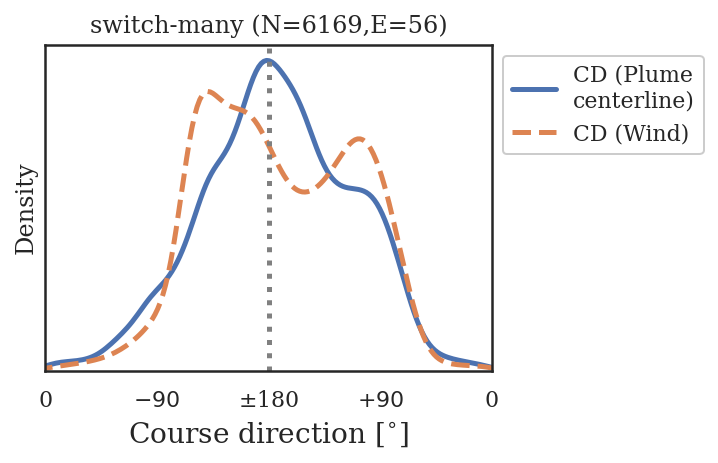

In [32]:
# Course angle
def plot_course_angle_dists(traj_df_stacked_subset, regime, dataset):
    
    label_dict = {
        'course_angle_ground': 'CD (Ground)',
        'course_angle_centerline': f'CD (Plume\ncenterline)',
        'course_angle_wind': 'CD (Wind)',        
    }
    title_dataset_dict = {
        'constantx5b5': 'constant',
        'noisy3x5b5': 'switch-many',
        'switch45x5b5': 'switch-once',
    }
    ls_dict = {
        'course_angle_ground': ':',
        'course_angle_centerline': '-',
        'course_angle_wind': '--',        
    }

    
    
#     fig = plt.figure(figsize=(4,3)) 
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    
    cols_show = [
#         'course_angle_ground',
             'course_angle_centerline',
             'course_angle_wind', 
                ]
    cols_colors = ['b', 'orange', 'g']

    for idx, col in enumerate(cols_show):
        sns.distplot(traj_df_stacked_subset[col],
                     hist=False,
                     rug=False,
                     ax=ax,
                     label=label_dict[col],
                     kde_kws={'ls':ls_dict[col], 'lw':2.5},
                     hist_kws=dict(alpha=0.9)) 
        
    # vertical lines
#     if 'RECOVER' in regime:
#         # vertical lines on MEDIANs
#         medians = {
#             'course_angle_ground': traj_df_stacked_subset['course_angle_ground'].median(),
#             'course_angle_centerline': traj_df_stacked_subset['course_angle_centerline'].median(),
#             'course_angle_wind': traj_df_stacked_subset['course_angle_wind'].median(),
#         }
#         plt.axvline(medians['course_angle_ground'], c='blue', ls=':')
#         plt.axvline(medians['course_angle_centerline'], c='orange', ls=':')
#         plt.axvline(medians['course_angle_wind'], c='green', ls=':')
        
#     else: 
#         # vertical lines on MODEs
#         for idx, kdeline in enumerate(ax.lines):
#             xs = kdeline.get_xdata()
#             ys = kdeline.get_ydata()
#             mode_idx = np.argmax(ys)
#             ax.vlines(xs[mode_idx], 0, ys[mode_idx], color=cols_colors[idx], ls=':', lw=2)



    plt.xlim(0,1)
    cols_show = ['course_angle_ground',
                 'centerline_angle',
                 'course_angle_centerline',
                 'wind_angle_ground',
                 'course_angle_wind',
                ]
    traj_df_stacked_subset.loc[:,cols_show]

    
    col = 'course_angle_ground'.replace('course_', 'agent_')
    ax = plt.gca()
    ax.set_xticks(ticks_dict[col])
    ax.set_xlabel('Course ' + r'direction [$^{\circ}$]', fontsize=14,)
    if col in ticklabels_dict.keys():
        ax.set_xticklabels(ticklabels_dict[col])


    # Add vertical lines
#     plt.axvline(x=0.5, c='grey', ls=':', label=r'$\pm 180^{\circ}$', lw=2.5)
    plt.axvline(x=0.5, c='grey', ls=':', lw=2.5)



    ax.set_yticks([])
#     ax.set_ylabel('')


    if 'noisy' in dataset:
        plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=1.0)

    N=len(traj_df_stacked_subset)
    E=len(traj_df_stacked_subset['ep_idx'].unique())
    title = f"{title_dataset_dict[dataset]} - {regime} - N={N}"
    title = f"{title_dataset_dict[dataset]} (N={N},E={E})"
    plt.title(title)
    
    fsuffix = f"{model_seed}_{dataset}_{regime}"
    fname = f"{outdir}/regime_dists_{fsuffix}_CD.png"
    print("Saving:", fname)
    plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')
    plt.show()
    
plot_course_angle_dists(traj_df_stacked_subset, regime, dataset)
# plot_course_angle_dists(traj_df_stacked_subset, 'RECOVER', dataset)

## Scale out to all cases

In [33]:
all_datasets = ['switch45x5b5', 'noisy3x5b5',]

if batchmode:
    all_datasets = ['switch45x5b5', 'noisy3x5b5', 'constantx5b5']    
    for dataset in all_datasets:
        centerline_df = load_centerline_df(dataset, traj_df_stacked)
        for regime in ['TRACK', 'RECOVER', 'SEARCH']:
            traj_df_stacked_subset = subset_centerline_angle(traj_df_stacked, regime, dataset)
            
            augment_agent_angle_centerline(traj_df_stacked_subset)
            augment_agent_angle_wind(traj_df_stacked_subset)    
            plot_agent_angle_dists(traj_df_stacked_subset, regime, dataset)

            augment_course_angle_centerline(traj_df_stacked_subset)
            augment_course_angle_wind(traj_df_stacked_subset)
            plot_course_angle_dists(traj_df_stacked_subset, regime, dataset)

In [34]:
traj_df_stacked_subset.columns
traj_df_stacked_subset['idx']

12    12
13    13
14    14
15    15
16    16
      ..
85    85
86    86
87    87
88    88
89    89
Name: idx, Length: 6169, dtype: int64